In [1]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 5.3 MB/s eta 0:00:00


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Bidirectional

from sklearn.metrics import confusion_matrix

In [3]:
df = pd.read_csv('/content/diabetes_risk_prediction_dataset.csv')

In [4]:
l=LabelEncoder()
df=df.apply(l.fit_transform)

In [5]:
df.sample(2)

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
245,6,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
417,15,0,1,1,1,1,1,0,0,1,1,1,1,0,0,0,1


In [7]:
X=df.drop("class",axis=1)
X = np.array(X.values.tolist())
y=np.array(df['class'].values.tolist())

In [8]:
X.shape

(520, 16)

In [ ]:
X.reshape(520,16,1)

In [10]:
y=to_categorical(l.fit_transform(y))

In [13]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.05, random_state=0)

In [14]:
num_labels=y.shape[1]

In [18]:
#bi directional tuning
def build_model(hp):
    model = Sequential()

    model.add(Bidirectional(LSTM(hp.Int('input_units', min_value=32, max_value=512, step=32), return_sequences=True), input_shape=(16, 1)))
    for i in range(hp.Int('n_layers', 1, 20)):
        model.add(Bidirectional(LSTM(hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), return_sequences=True)))
    model.add(Bidirectional(LSTM(hp.Int('layer_2_neurons', min_value=32, max_value=512, step=32))))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(num_labels, activation=hp.Choice('dense_activation', values=['softmax', 'sigmoid'], default='softmax')))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [19]:
#tuning
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='model_2',
    project_name='model_2')

In [20]:
#tuning
tuner.search(X_train, y_train,
             epochs=2,
             validation_data=(X_test, y_test))

Trial 5 Complete [00h 01m 13s]
val_accuracy: 0.9038461446762085

Best val_accuracy So Far: 0.9038461446762085
Total elapsed time: 00h 14m 00s


In [21]:
model = tuner.get_best_models(num_models=1)[0]

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 16, 960)           1850880   
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 16, 512)           2492416   
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 16, 448)           1320704   
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               590848    
 onal)                                                           
                                                                 
 dropout (Dropout)           (None, 256)               0

In [27]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

1/1 [==============================] - 0s 114ms/step


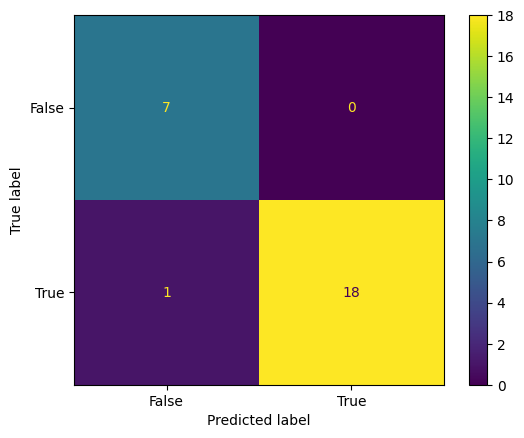

In [28]:
cm = metrics.confusion_matrix(y_true, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()